In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import cv2
import sys
import copy
import json
import random
import rasterio
import numpy as np
import tifffile as tiff
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model, model_from_json

from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

Segmentation Models: using `keras` framework.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
sys.path.insert(0, '../')
from height_model_scripts.loss_functions import rmse
from height_model_scripts.metrics import F1_metric, RMSE, MAE, R2, MBE, F1_metric
from height_model_scripts.height_model_scripts import Generator
from height_model_scripts.save_pred import save_pred, tif2geojson

### Split on test, train, validation

In [4]:
train_img_list = []
test_img_list = []
val_img_list = []

train_list_split = ['0_0', '0_1', '0_2',
               '1_0', '1_2',
               '2_0', '2_1', '2_3', '2_4', '2_5',
               '3_1', '3_2', '3_3',
               '4_1', '4_3', '4_4', '4_5',
               '5_1', '5_2', '5_3', '5_4',
               '6_0', '6_1', '6_2', '6_4',
               '7_0', '7_1', '7_2', '7_3', '7_4']
val_list_split = ['1_1', '2_2', '4_2', '6_3']

# krasnoborsk
for folder in os.listdir('/home/user/data/krasnoborsk/world_view/'):
    if 'tif' in folder or 'xml' in folder or folder == 'lines':
        continue
    for file_name in os.listdir('/home/user/data/krasnoborsk/world_view/{}'.format(folder)):
        tmp_ind = file_name.split('_')[0]+'_'+file_name.split('_')[1]
        if tmp_ind in train_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in train_img_list:
            train_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]
        elif tmp_ind in val_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in val_img_list \
            and folder == '0':
            val_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]

# Novoshinsk
dse_pathechs = ['0_0', '0_1', '0_2',
               '1_0', '1_1', '1_2', '1_3',
               '2_0', '2_1', '2_2', '2_3', '2_4', 
               '3_0', '3_1', '3_2', '3_3', '3_4',
               '4_0', '4_1', '4_3', '4_4',
               '5_3', '5_4',
               '6_2', '6_3', '6_4',
               '7_2', '7_3', '7_4',
               '8_2', '8_3', '8_4']

for file_ind in [0, 1, 7, 9]: 
    for patch_ind in dse_pathechs:
        i, j = patch_ind.split('_')
        if patch_ind +'_channel_0.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)) \
            or patch_ind +'_class_606.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)):
            continue
        if patch_ind in ['1_1', '2_2', '4_4']:
            test_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]
        else:
            train_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]


## New model

In [5]:
batch_size=20 
num_channels=3

gdal_file_path = './'

generator = Generator(train_img_list, val_img_list, batch_size, num_channels, gdal_file_path=gdal_file_path)

generator.augm = True              # just geometric rotation is applied
generator.color_aug_prob = 1       # add color augm

generator.sharpen_flag = False     # flag to switch pansharpaning
generator.forest_mask = True       # add forest mask if it is provided

generator.lidar_coef = 2.5           # parameter for height resolution downsampling
generator.lidar_resolution = 1     # resolution of height data
generator.target_resolution = 2    # target resolution both for height and imagery
generator.clip_value = 40.         # the greatest height value 

generator.classifier_mode = 'regression'
generator.channels_list = ['channel_0.tif', 'channel_1.tif', 'channel_2.tif']

In [6]:
generator.write_gdalinfo_file()

## Save generator parametrs

In [7]:
generator_state = copy.deepcopy(generator.__dict__)
del generator_state['data_gdal']
del generator_state['img_prob']

nb_name = 'regr_rgb_wv.ipynb'

save_file = nb_name.split('.')[0] + '.json'
with open(save_file, 'w') as f:
    json.dump(generator_state, f)

## Check outputs

Text(0.5,1,'lidar')

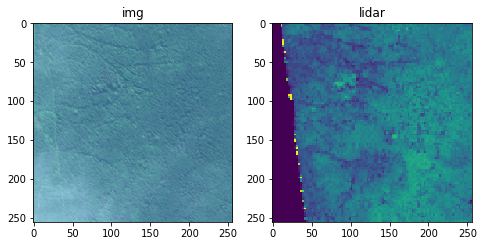

In [8]:
# check output
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

Text(0.5,1,'lidar')

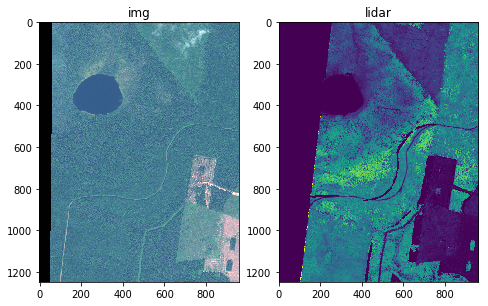

In [9]:
generator.augm = False
generator.full_img = True
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[2])
generator.full_img = False
generator.augm = True   

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

## Set model

In [7]:
model = Unet(backbone_name='inceptionresnetv2', input_shape=(None, None, num_channels), 
                  encoder_weights=None, activation='sigmoid')
loss =  rmse
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [8]:
model_name = 'regr_rgb_wv'
save_dir = '/home/user/data/example/data/Forestry_inventory/Height_model_paper/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=4,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [12]:
history=model.fit_generator(generator.train_gen(),epochs=25, #35, 25 20
                           steps_per_epoch=200,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=100)#30

Epoch 1/25
200/200 [==============================] - 170s 848ms/step - loss: 0.1535 - rmse: 0.1535 - val_loss: 0.1520 - val_rmse: 0.1520

Epoch 00001: val_loss improved from inf to 0.15195, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_wv.h5

Epoch 00001: val_loss improved from inf to 0.15195, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_wv.hdf5
Epoch 2/25
200/200 [==============================] - 133s 665ms/step - loss: 0.1468 - rmse: 0.1468 - val_loss: 0.2250 - val_rmse: 0.2250

Epoch 00002: val_loss did not improve from 0.15195

Epoch 00002: val_loss did not improve from 0.15195
Epoch 3/25
200/200 [==============================] - 134s 672ms/step - loss: 0.1440 - rmse: 0.1440 - val_loss: 0.2169 - val_rmse: 0.2169

Epoch 00003: val_loss did not improve from 0.15195

Epoch 00003: val_loss did not improve from 0.15195
Epoch 4/25
200/200 [==============================] - 134s 671ms/step - lo

In [17]:
# serialize model to JSON without height
model_name += '_v1'
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [9]:
model.load_weights(save_dir+"{}.h5".format(model_name)) 

## Evaluation

In [25]:
generator.augm  = False
prediction, full_mask = generator.pred_img(model=model, img_path=val_img_list[3])
generator.augm  = True

Text(0.5,1,'lidar')

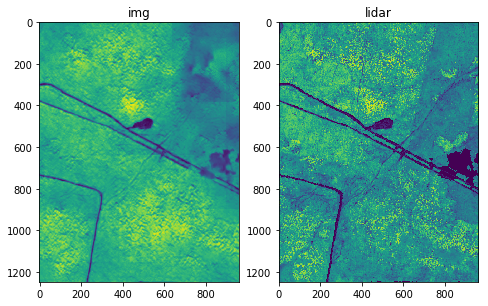

In [26]:
fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow((prediction[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow((full_mask[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('lidar')

In [27]:
prediction.shape

(1249, 959, 1)

In [28]:
prediction = prediction[:,:600,:]
full_mask = full_mask[:,:600,:]
cur_rmse = RMSE(prediction*generator.clip_value, full_mask*generator.clip_value)
cur_mae = MAE(prediction*generator.clip_value, full_mask*generator.clip_value)
cur_r2 = R2(prediction*generator.clip_value, full_mask*generator.clip_value)
cur_mean_bias = MBE(prediction*generator.clip_value, full_mask*generator.clip_value)
print(cur_rmse, cur_mae, cur_r2, cur_mean_bias)

4.454 3.537 0.334 -1.019758307996423


Text(0.5,1,'lidar')

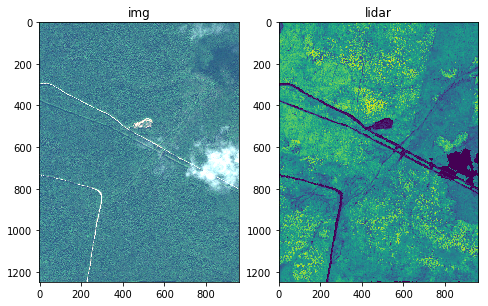

In [22]:
generator.augm = False
generator.full_img = True
img_tmp, mask_tmp = generator.get_img_mask_array(val_img_list[3])
generator.full_img = False
generator.augm = True   

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

In [22]:
print('RMSE', RMSE(prediction*generator.clip_value, full_mask*generator.clip_value))
print('MAE', MAE(prediction*generator.clip_value, full_mask*generator.clip_value))

RMSE 4.637
MAE 3.667


In [19]:
print('RMSE', RMSE(prediction*generator.clip_value, full_mask*generator.clip_value))
print('MAE', MAE(prediction*generator.clip_value, full_mask*generator.clip_value))

RMSE 4.606
MAE 3.643


In [18]:
generator.augm  = False
average_rmse = 0
average_mae = 0
average_r2 = 0
average_mean_bias = 0
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    cur_rmse = RMSE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mae = MAE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_r2 = R2(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mean_bias = MBE(prediction*generator.clip_value, full_mask*generator.clip_value)
    average_rmse += cur_rmse
    average_mae += cur_mae
    average_r2 += cur_r2
    average_mean_bias += cur_mean_bias
    print(ind, 'rmse: ', cur_rmse, ' mae: ', cur_mae,  ' r2: ', cur_r2,  ' mbe: ', cur_mean_bias, )

print('~~~~~~~~~~~~~~~~')
print('Average RMSE: ', round(average_rmse / len(val_img_list), 3))
print('Average MAE: ', round(average_mae / len(val_img_list), 3))
print('Average R2: ', round(average_r2 / len(val_img_list), 3))
print('Average mean bias: ', round(average_mean_bias / len(val_img_list), 3))

0 rmse:  4.665  mae:  3.115  r2:  0.561  mbe:  0.20837784522930508
1 rmse:  3.927  mae:  3.05  r2:  0.536  mbe:  1.0345447748929373
2 rmse:  4.837  mae:  3.637  r2:  0.671  mbe:  -0.22827006443176215
3 rmse:  4.637  mae:  3.667  r2:  0.314  mbe:  -0.9172702338502879
~~~~~~~~~~~~~~~~
Average RMSE:  4.516
Average MAE:  3.367
Average R2:  0.52
Average mean bias:  0.024


In [11]:
num_cl = 4
F1_score = np.zeros((num_cl))
class_names=['0-4', '4-10', '10-20', '>20']
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    
    prediction *= generator.clip_value
    full_mask *= generator.clip_value

    pred = np.zeros((1, prediction.shape[0], prediction.shape[1], num_cl))
    mask = np.zeros((1, full_mask.shape[0], full_mask.shape[1], num_cl)) 

    pred[:,:,:,0] = np.where(prediction[:,:,0]>0, 1, 0) * np.where(prediction[:,:,0]<4, 1, 0)
    mask[:,:,:,0] = np.where(full_mask[:,:,0]>0, 1, 0) * np.where(full_mask[:,:,0]<4, 1, 0)

    pred[:,:,:,1] = np.where(prediction[:,:,0]>=4, 1, 0) * np.where(prediction[:,:,0]<10, 1, 0)
    mask[:,:,:,1] = np.where(full_mask[:,:,0]>=4, 1, 0) * np.where(full_mask[:,:,0]<10, 1, 0)

    pred[:,:,:,2] = np.where(prediction[:,:,0]>=10, 1, 0) * np.where(prediction[:,:,0]<20, 1, 0)
    mask[:,:,:,2] = np.where(full_mask[:,:,0]>=10, 1, 0) * np.where(full_mask[:,:,0]<20, 1, 0)

    pred[:,:,:,3] = np.where(prediction[:,:,0]>=20, 1, 0)
    mask[:,:,:,3] = np.where(full_mask[:,:,0]>=20, 1, 0)

    F1_score += F1_metric(pred, mask, num_cl = num_cl, class_names=[])
    

0 : precision  0.736  recall  0.626  f1  0.676
 
1 : precision  0.597  recall  0.461  f1  0.52
 
2 : precision  0.746  recall  0.967  f1  0.842
 
3 : precision  0.718  recall  0.148  f1  0.245
 
0 : precision  0.665  recall  0.725  f1  0.694
 
1 : precision  0.466  recall  0.469  f1  0.467
 
2 : precision  0.811  recall  0.896  f1  0.851
 
3 : precision  0.094  recall  0.002  f1  0.004
 
0 : precision  0.886  recall  0.747  f1  0.811
 
1 : precision  0.368  recall  0.236  f1  0.288
 
2 : precision  0.556  recall  0.813  f1  0.661
 
3 : precision  0.641  recall  0.394  f1  0.489
 
0 : precision  0.894  recall  0.201  f1  0.328
 
1 : precision  0.16  recall  0.113  f1  0.132
 
2 : precision  0.743  recall  0.769  f1  0.756
 
3 : precision  0.484  recall  0.48  f1  0.482
 


In [12]:
print(F1_score / len(val_img_list))
print(np.sum(F1_score / len(val_img_list))/num_cl)

[0.62712681 0.35191591 0.77759731 0.30473856]
0.51534464965262


## Save prediction

In [10]:
model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [9]:
json_file = open(save_dir+"{}.json".format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(save_dir+"{}.h5".format(model_name)) 

FileNotFoundError: [Errno 2] No such file or directory: '/home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_wv.json'

In [39]:
val_img_list

['/home/user/data/krasnoborsk/world_view/0/6_3',
 '/home/user/data/krasnoborsk/world_view/0/2_2',
 '/home/user/data/krasnoborsk/world_view/0/4_2',
 '/home/user/data/krasnoborsk/world_view/0/1_1']

In [57]:
r = tiff.imread('/home/user/data/krasnoborsk/world_view/0/2_2_channel_1.tif')
height = tiff.imread('/home/user/data/krasnoborsk/world_view/0/height_2_2.tif')

Text(0.5,1,'lidar')

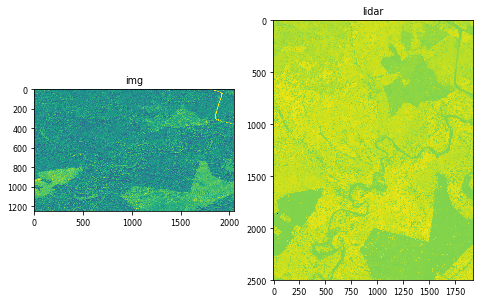

In [59]:
fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(r)
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(height)
a.set_title('lidar')

In [65]:
generator.augm  = False
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    height_name = '/home/user/data/krasnoborsk/world_view/0/height_6_3.tif'
    save_pred(img_to_save=prediction[:,:,0]*generator.clip_value, save_dist='../images/tmp.tif', \
          info_img=height_name, crs=4326)
    tif2geojson(source_dir='../images/', tif_name='tmp', geojson_path='../images/tmp.geojson')
    break
generator.augm  = True

1918 2498 (2498, 1918)


In [66]:
tmp = tiff.imread('../images/tmp.tif')

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fa4b308ddd8>)

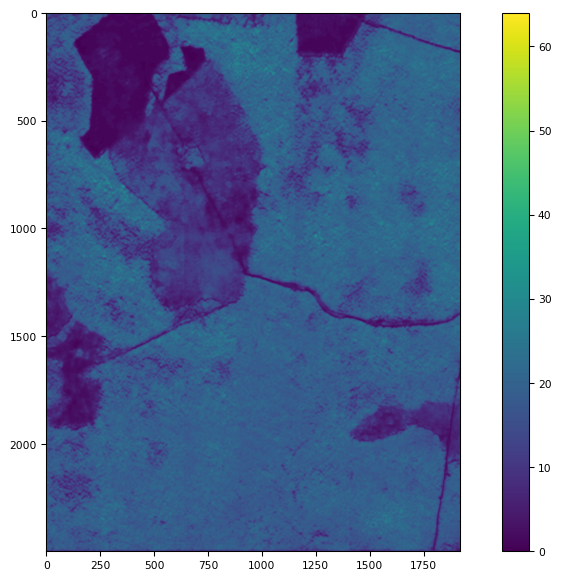

In [68]:
tiff.imshow(tmp.clip(0, 40))